# Visualizing Science - Citation Network Clustering

ここではネットワークサイエンスの手法を用いて、論文の引用ネットワークを解析します。  
以下のコンテンツについて取り扱います。


*   学術論文における引用ネットワークとは
*   引用ネットワークの構成
*   ネットワークのクラスタリング


## 前準備
前章で用いたOpenAlexを用いてまずはデータを取得します

In [1]:
%pip install pyalex
%pip install networkx
%pip install tqdm
%pip install japanize-matplotlib
%pip install leidenalg

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

In [1]:
import pandas as pd
from pyalex import Works, Authors, Sources, Institutions, Concepts, Funders
import pyalex
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import random
import time
import textwrap
import math
import util
from collections import Counter
from itertools import combinations


# pyalex.config.email = "your@email.address"
pyalex.config.email = "zhmuler@gmail.com"

/Users/ti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 引用関係について
今回扱うネットワークは論文の引用関係を表したネットワークになります。
具体的には  
ノード：論文  
エッジ：引用関係  
として表現されています。

今回は引用関係がエッジとなっている。
「引用する側」と「引用される側」で区別することが可能であり、有向グラフと考えることができる。  


![citation](./supplementary/2_1citation.png)

### 直接引用、共引用と書誌結合
引用ネットワークのエッジの結び方として、直接引用、共引用、書誌結合が存在します。

![network_rules](./supplementary/2_2edge_rules.png)

## 特定のField内の論文での共引用ネットワーク

OpenAlexにおいて、Topicは以下の画像のような関係になっています。  
ここでは特定のFieldから論文を1万件取得して、そこで共引用ネットワークを構築してみましょう。  
Field_idの対応はこちらのページから確認できます。

![OpenAlexにおけるTopic](https://2520693015-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2FpHVuV3Ib5KXeBKft4Kcl%2Fuploads%2Fgit-blob-a41f526188c79e0fc5e09e9fea3eb25a1e525b3e%2Ftopics_diag1.png?alt=media)

In [3]:
# 取得したいfield_idを指定
subfield_id = 1311 #Genetics

pyalexObj = Works().filter(primary_topic={"subfield":{"id":subfield_id}}, cited_by_count=f">0").select(["id","referenced_works","primary_topic"])
field_count = pyalexObj.count()
field_works = util.getAll(pyalexObj.sample(10000, seed=42))

print(f"取得した論文数/分野内の論文数：{len(field_works)}/{field_count} ({round(len(field_works)/field_count*100,2)}%)")

50it [01:08,  1.36s/it]

取得した論文数/分野内の論文数：10000/975340 (1.03%)


In [4]:
# 共引用ネットワークの描画
THRESHOLD = 3

def create_tuples(group):
    ids = group["id"].tolist()
    id_combinations = list(combinations(ids, 2))  # Generate all combinations of IDs
    return id_combinations

works = pd.DataFrame(field_works)
works = works.drop_duplicates(subset="id")
works["primary_topic"] = works["primary_topic"].apply(lambda x: x["id"].split("/")[-1].replace("T","")).astype(int)

result = works[["id","referenced_works"]].explode(column="referenced_works").groupby("referenced_works").apply(create_tuples).reset_index(name="id_tuples")
field_edge_list = pd.DataFrame(np.sum(result["id_tuples"].values))

tuple_array = [tuple(row) for _, row in field_edge_list.iterrows()]

tuple_counts = Counter(tuple_array)
filtered_tuples = [tpl for tpl, count in tuple_counts.items() if count >= THRESHOLD]

print(len(field_edge_list))
print(len(filtered_tuples))

137833
8678


In [115]:
# G の作成
G = nx.Graph()
G.add_nodes_from(works["id"])
G.add_edges_from(filtered_tuples)

largest_component = max(list(nx.connected_components(G)), key=len)
largest_component_subgraph = G.subgraph(largest_component)

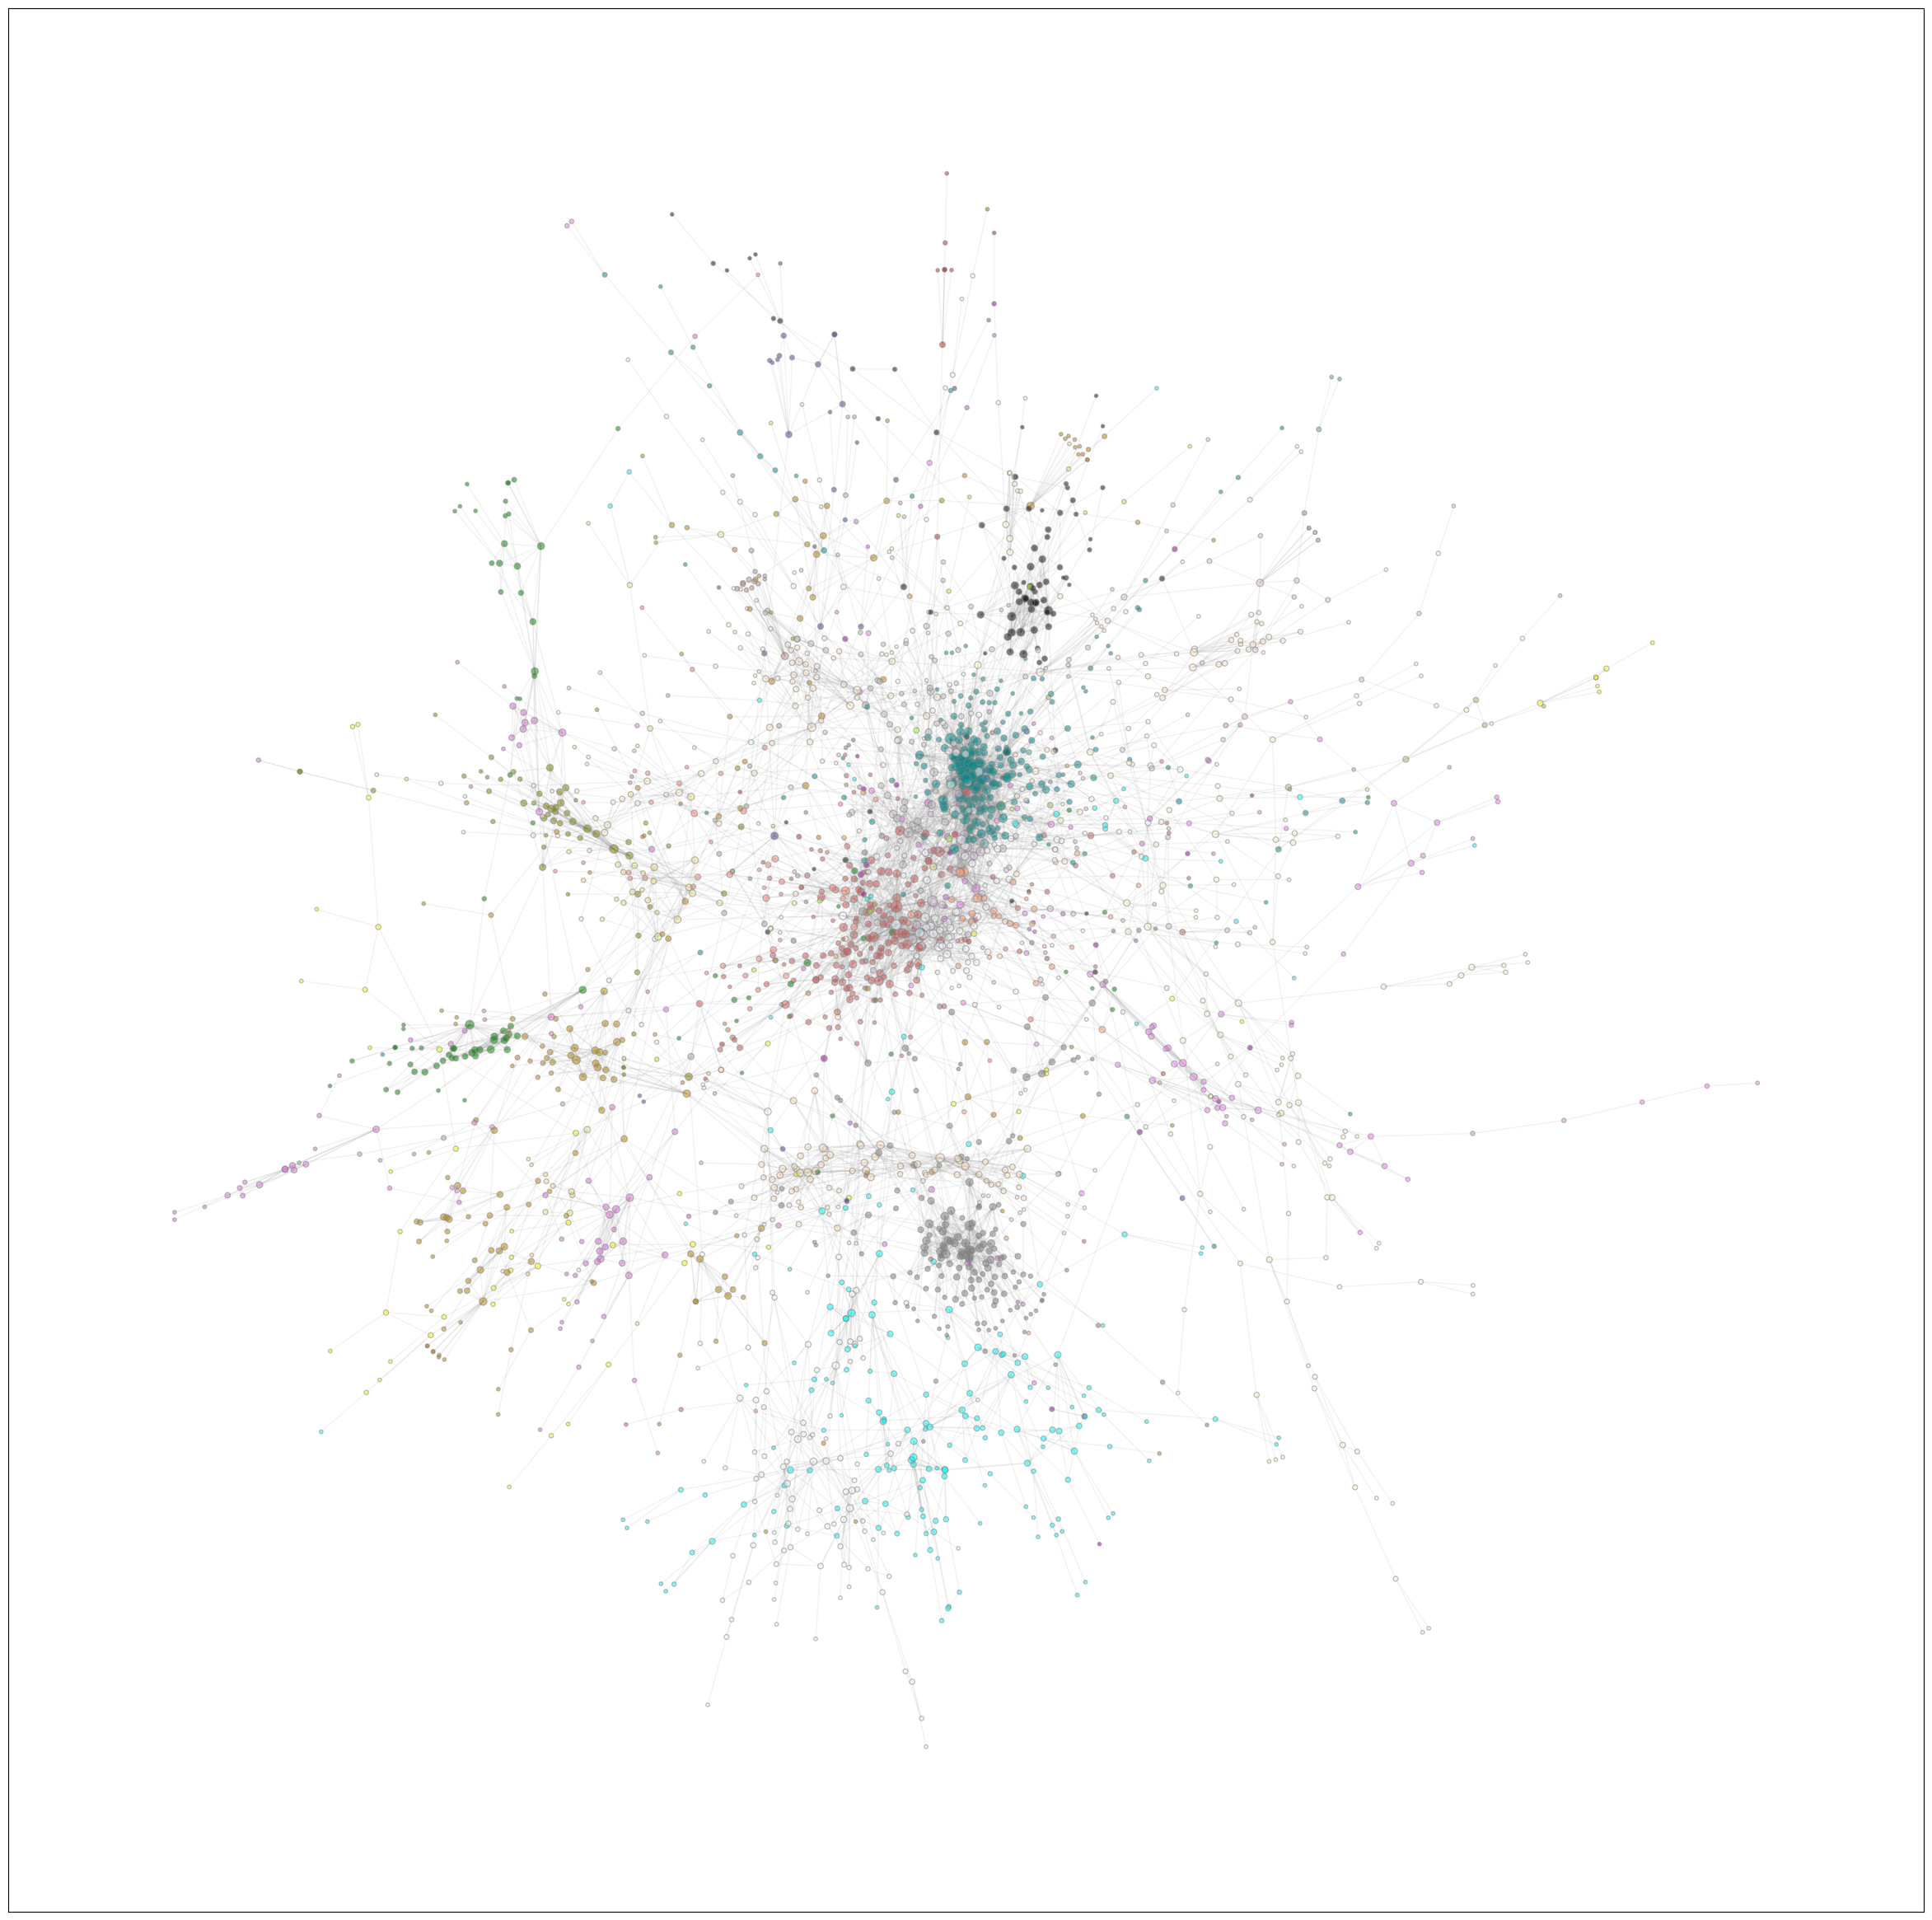

In [117]:
import matplotlib.colors as mplc

random.seed(42)

# ノードの色を指定
cmap = random.sample(list(mplc.CSS4_COLORS.values()),works["primary_topic"].nunique()) 
color_dict = {value: cmap[i % works["primary_topic"].nunique()] for i, value in enumerate(works["primary_topic"].unique())}

node_colors = [color_dict[works[works["id"]==node]['primary_topic'].values[0]] for node in largest_component_subgraph.nodes()]
node_sizes = [10 * math.sqrt(largest_component_subgraph.degree()[node]) for node in largest_component_subgraph.nodes()]

pos = nx.spring_layout(largest_component_subgraph)
# グラフの描画
plt.figure(figsize=(30, 30))
nx.draw_networkx_nodes(largest_component_subgraph, pos=pos, node_color=node_colors, node_size=node_sizes,alpha=0.5,edgecolors='gray')
nx.draw_networkx_edges(largest_component_subgraph, pos=pos ,edge_color="gray",alpha=0.1)
plt.show()

## クラスタリングの実施

ネットワークにはノードが密集しているようなコミュニティ構造が見られることが多々あります。このような構造を有効に検出するための手法としてクラスタリングが挙げられます。  
ネットワークにおけるクラスタリング手法は様々ありますが、多くの場合モジュラリティという指標を最適化することでコミュニティ構造を検出することが可能となります。  

$$
Q = \frac{1}{2m} \sum_{i,j} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \delta(c_i, c_j)
$$

$Q$: モジュラリティ \\
$A_{ij}$: ノード$i$とノード$j$の接続関係を表す非負の値（0か1の二値で表現される） \\
$k_i$: ノード$i$の次数 \\
$c_i$: ノード $i$ が属するコミュニティ \\
$\delta(c_i, c_j)$: コミュニティ $c_i$ と $c_j$ が同じかどうかを示すδ関数（0か1の二値で表現される） \\
$m$: エッジの総数 \\

モジュラリティを最適化するアルゴリズムとして長らくLouvain法と呼ばれる手法を用いられてきましたが、近年ではその改良版であるleiden法を用いることが増えてきました。  
今回もleiden法を用いて共引用ネットワークのクラスタリングを行ってみましょう。



In [123]:
import networkx as nx
import igraph as ig

# Convert NetworkX graph to an iGraph graph
ig_G = ig.Graph.from_networkx(largest_component_subgraph)

# Run Leiden algorithm to cluster the graph with a specified number of clusters
num_clusters = 5  # Specify the number of clusters
partition = ig_G.community_leiden(objective_function="modularity", n_iterations=-1, resolution=1.0)

# Assign cluster labels to nodes in the NetworkX graph
cluster_labels = partition.membership

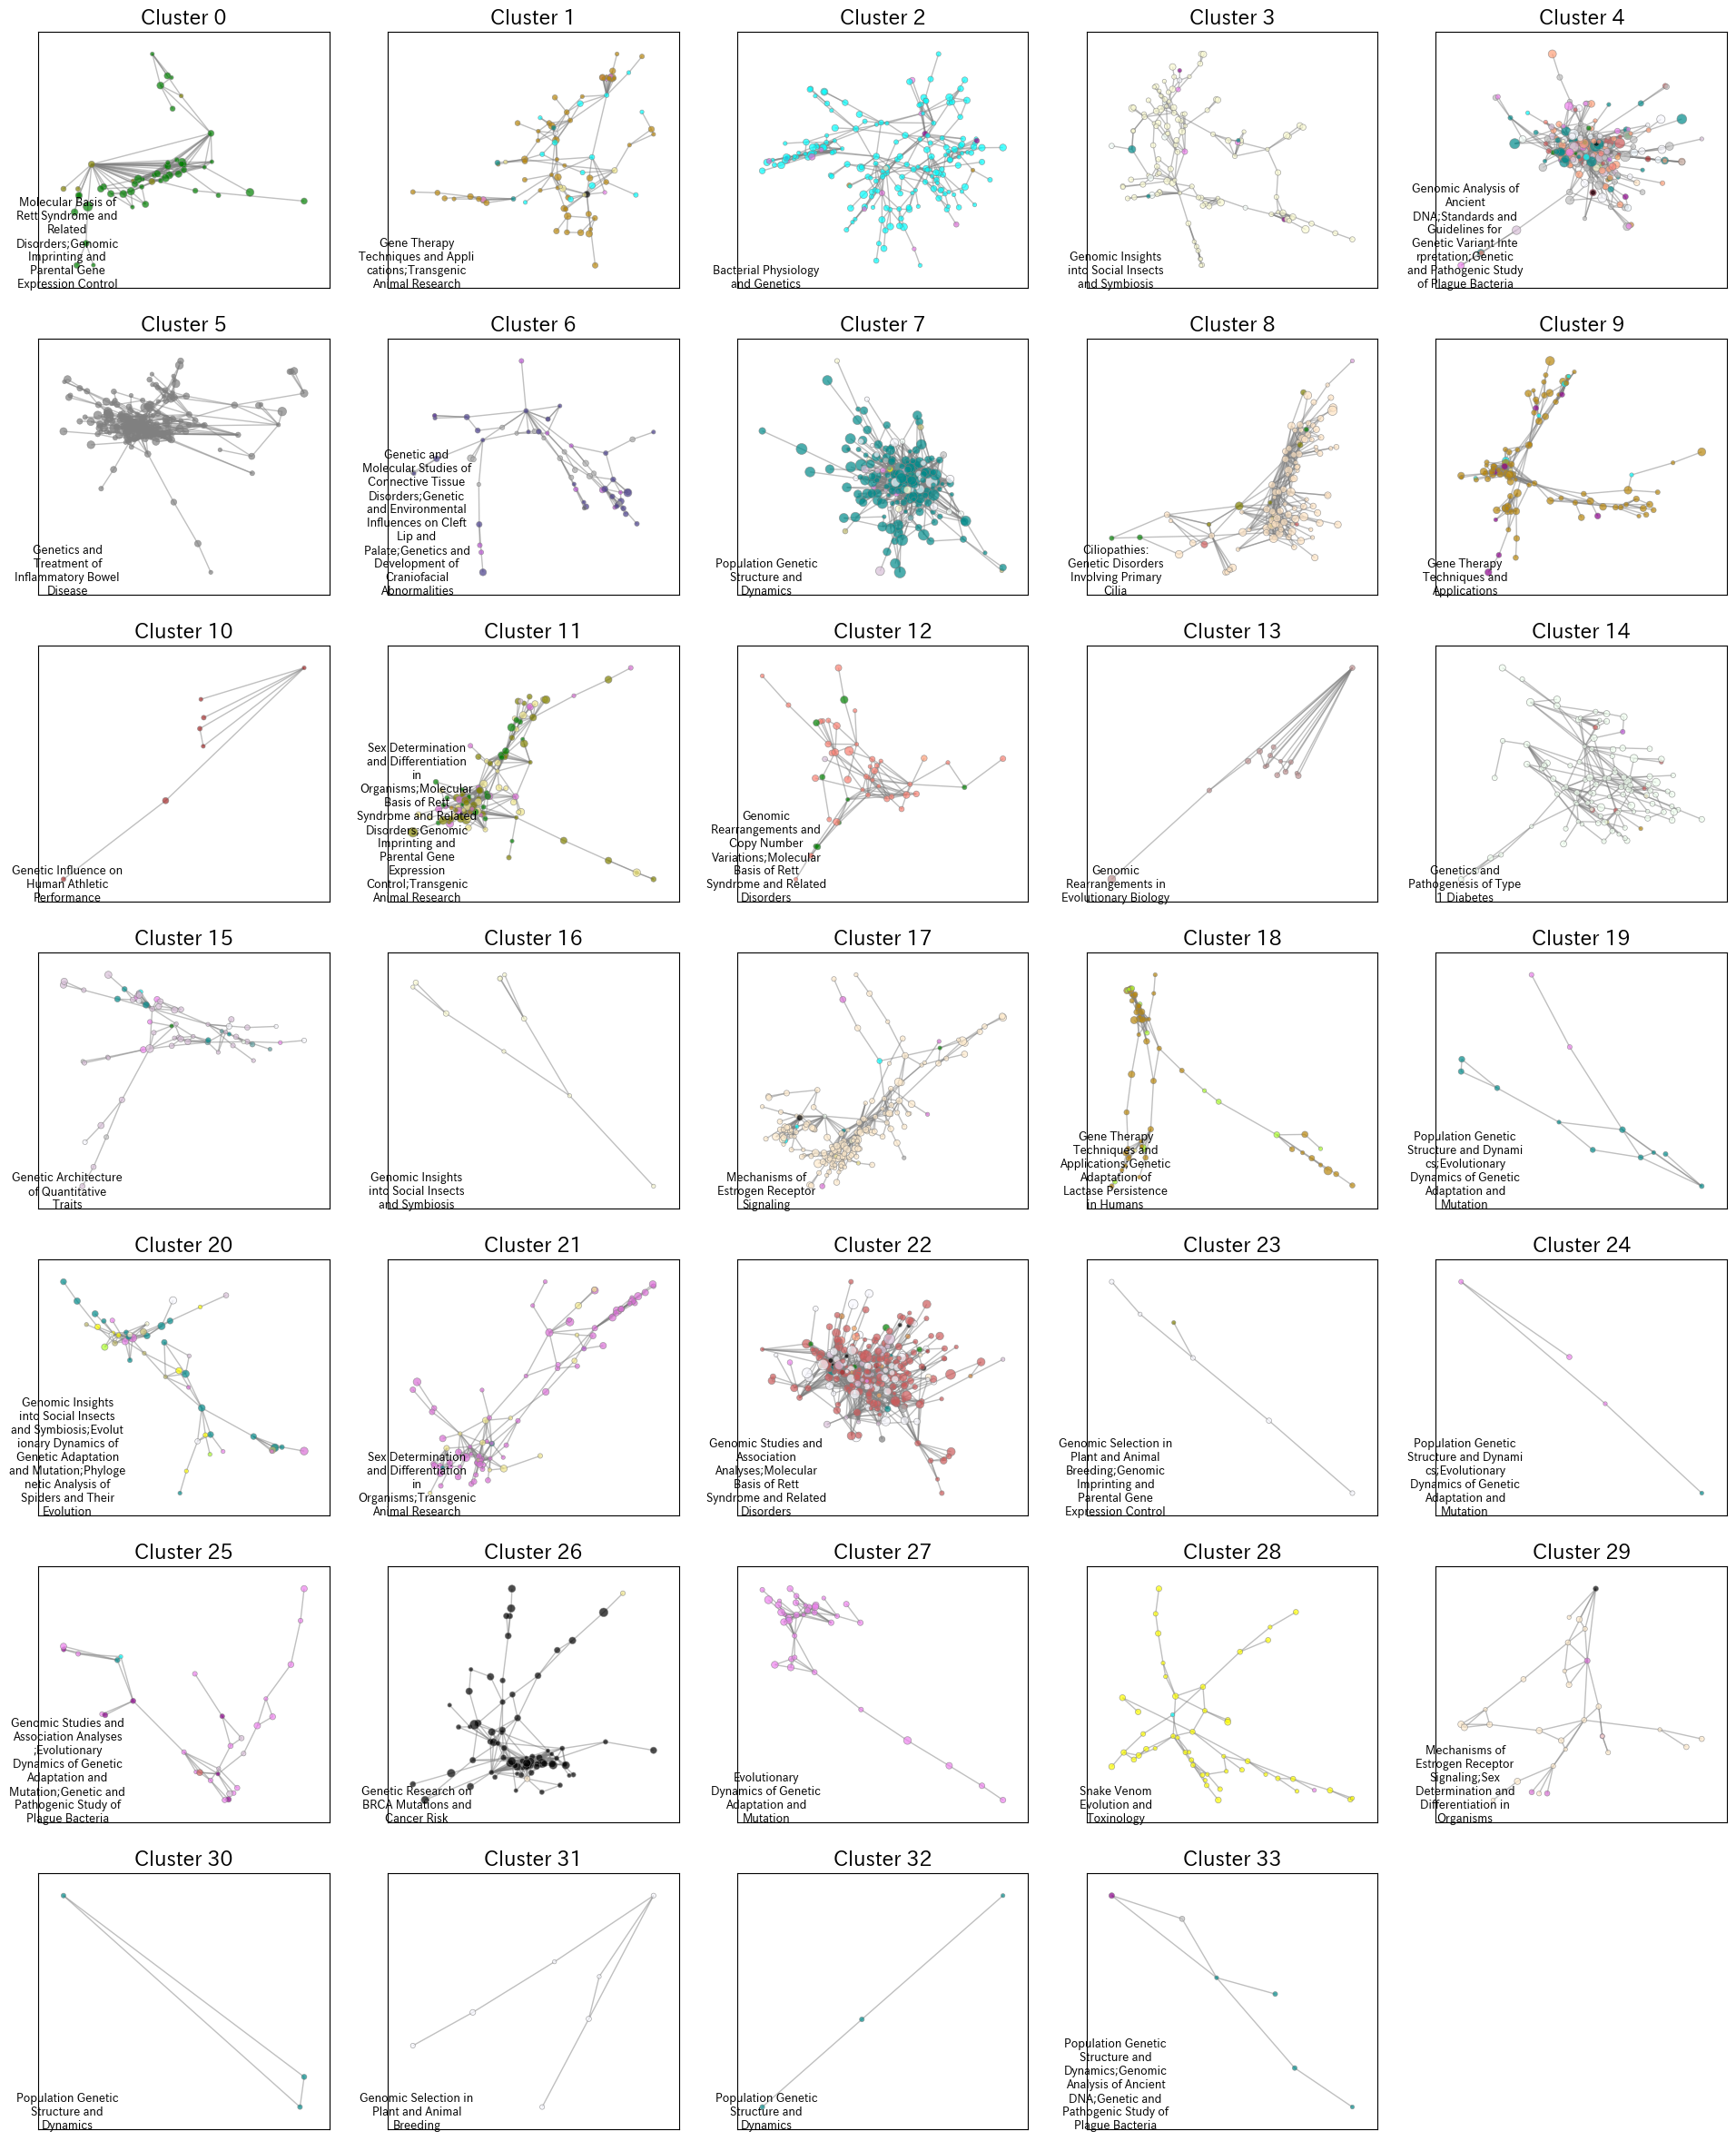

In [125]:
# Draw the graph with nodes colored according to their cluster membership

# Create a dictionary to store the nodes of each cluster
cluster_nodes = {cluster: [node for node, label in zip(largest_component_subgraph.nodes(), cluster_labels) if label == cluster] for cluster in set(cluster_labels)}
topic_name = pd.read_csv("./supplementary/OpenAlex_topic_mapping_table.csv")

# Draw the subgraphs for each cluster
plt.figure(figsize=(24, 30))

for cluster, nodes in cluster_nodes.items():
    plt.subplot(len(cluster_nodes)//5+1, 5, cluster + 1)  # Create a subplot for each cluster

    # Get the correct topic name that open alex has assigned
    topics = works['primary_topic'][works["id"].isin(nodes)]
    major_topics_cluster = topics.unique()[topics.value_counts()>len(topics)*0.1] # more than 10 % of node has the topic
    major_topics_cluster_names = ";".join(topic_name["topic_name"][topic_name["topic_id"].isin(major_topics_cluster)].values)
    wrapped_text = textwrap.fill(major_topics_cluster_names, width=20)

    node_colors = [color_dict[works[works["id"]==node]['primary_topic'].values[0]] for node in nodes]
    node_sizes = [10 * math.sqrt(largest_component_subgraph.degree()[node]) for node in nodes]

    nx.draw_networkx_edges(largest_component_subgraph.subgraph(nodes), pos=pos, edge_color='gray',alpha=0.5)
    nx.draw_networkx_nodes(largest_component_subgraph.subgraph(nodes), pos=pos, node_color=node_colors, node_size=node_sizes, edgecolors='gray',linewidths=0.5,alpha=0.7)
    plt.title(f"Cluster {cluster}", fontsize=16)
    plt.text(0.1, 0, wrapped_text, ha='center',fontsize=9, transform=plt.gca().transAxes)

plt.show()


In [27]:
import igraph as ig

# Create an igraph Graph object from your NetworkX graph G
# Assuming G is your NetworkX graph object
# First, get the edges as tuples from G
edges = largest_component_subgraph.edges()
# Next, create an igraph Graph object from the edges
ig_graph = ig.Graph.TupleList(edges, directed=False)

# Perform clustering using the Leiden algorithm
partition = ig_graph.community_leiden(resolution_parameter=0.5)

# Get the clusters
clusters = partition.subgraphs()

desired_num_clusters = 5  # Specify the desired number of clusters
if len(clusters) != desired_num_clusters:
    # You may need to implement custom logic to adjust the clusters based on your specific requirements
    # For example, you could merge or split clusters to achieve the desired number of clusters
    # Here, we're just printing out the current clusters
    print("Current clusters:")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i+1}: {cluster.vs['name']}")


Current clusters:
Cluster 1: ['https://openalex.org/W2007019368', 'https://openalex.org/W4205498119', 'https://openalex.org/W2065835146']
Cluster 2: ['https://openalex.org/W1985166802', 'https://openalex.org/W2536912811', 'https://openalex.org/W2085124069', 'https://openalex.org/W2040263918', 'https://openalex.org/W2122584840', 'https://openalex.org/W2166070939']
Cluster 3: ['https://openalex.org/W1015214941', 'https://openalex.org/W2950077533', 'https://openalex.org/W2749146127', 'https://openalex.org/W2151736671', 'https://openalex.org/W2146234294', 'https://openalex.org/W2621197342', 'https://openalex.org/W2166164581', 'https://openalex.org/W2004390372', 'https://openalex.org/W3205337271', 'https://openalex.org/W2060647663', 'https://openalex.org/W2789548112']
Cluster 4: ['https://openalex.org/W2153806589', 'https://openalex.org/W2073503004', 'https://openalex.org/W2904816091']
Cluster 5: ['https://openalex.org/W1973970793', 'https://openalex.org/W1501428507', 'https://openalex.org/

/var/folders/fn/7ymcb_ld5c78xqjx1s653sbm0000gn/T/ipykernel_84285/678612423.py:11: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  partition = ig_graph.community_leiden(resolution_parameter=0.5)


In [ ]:
import leidenalg

# leiden法はランダム性があるので一貫した結果を得るためにseedを固定する
SEED = 42
random.seed(SEED)

def leiden_clustering(graph):
    # Leidenクラスタリングを実行
    partition = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition)
    # クラスタリング結果をノード属性に追加
    for node, cluster_id in enumerate(partition):
        graph.nodes[node]['cluster'] = cluster_id
    return graph

springer_graph = leiden_clustering(G)

NameError: name 'springer_graph' is not defined

クラスタによってノードを色分けしたグラフは以下のようになります。

## Appendix

### ある論文誌で発行されている論文の引用ネットワーク

次に1つの論文誌に着目してネットワークを構築してみましょう。第一章でも登場したsourceに関するコードです。 日本で出版されている論文誌の中で、規模が大きいものを取り上げてみます

In [130]:
source = Sources().filter(works_count=">10000", country_code="JP").get()[:10]
pd.DataFrame(map(lambda x: [x["id"],x["display_name"], x["host_organization_name"], x["is_oa"],x["works_count"]],source),
            columns=["id","論文誌名","論文誌発行機関","OA誌かどうか", "累計論文発行数"])

,id,論文誌名,論文誌発行機関,OA誌かどうか,累計論文発行数
0,https://openalex.org/S4210210193,Journal of the Japan Society of Mechanical Eng...,Japan Society Mechanical Engineers,False,61373
1,https://openalex.org/S4210231715,Nippon Hoshasen Gijutsu Gakkai Zasshi,None,False,49308
2,https://openalex.org/S119212824,Journal of the Physical Society of Japan,Physical Society of Japan,False,43878
3,https://openalex.org/S95305481,Bulletin of the Chemical Society of Japan,Oxford University Press,False,38043
4,https://openalex.org/S2752698192,The Japanese Journal of Urology,Japanese Dermatological Association,True,32901
5,https://openalex.org/S190179609,Japanese Journal of Pharmacology,Japanese Pharmacological Society,True,31362
6,https://openalex.org/S90825563,Chemistry Letters,Oxford University Press,False,29429
7,https://openalex.org/S3861430,Chemical & Pharmaceutical Bulletin,Pharmaceutical Society of Japan,True,28659
8,https://openalex.org/S2764346059,Agricultural and biological chemistry,Oxford University Press,False,26866
9,https://openalex.org/S2764386467,Journal of the Pharmaceutical Society of Japan,Pharmaceutical Society of Japan,False,24849


今回は日本機械学会の論文でネットワークを構築してみましょう。
論文を取得する際に、論文誌のidが必要になるので上で判明したものを使います。

In [2]:
source_id = "https://openalex.org/S4210210193"	
sample_works_jounal = util.getAll(Works().filter(locations={"source":{"id":source_id}},publication_year=">1970").select(["id","referenced_works"]))

Fetching 33990 objects. it may takes 8.5 minutes


171it [03:01,  1.06s/it]


### 特定のKWを持つ論文による引用ネットワーク

上記では特定のFieldに絞って論文群を抽出しましたが、特定のキーワードを元にして作ることもできます。

In [10]:
keyword = "kinesin"
sample_works_keyword = util.getAll(Works().search(keyword).select(["id","referenced_works"])) # Title, Abstract で検索　→　55,538件
# sample_works_keyword = util.getAll(Works().filter(keywords={"keyword":keyword}).select(["id","referenced_works"])) # keywordで検索　→　830件

Fetching 55538 objects. it may takes 13.88 minutes


17it [00:26,  1.49s/it]